<h1 align="center"> INF6804 Lab 2: BRIEF descriptor </h1>
<br>
<h3 align="center"> Daniel Wang, Oumayma Messoussi </h3>
<br>

In [37]:
import numpy as np
from skimage import data, io
from skimage.feature import BRIEF, corner_peaks, corner_fast, match_descriptors, plot_matches
import matplotlib.pyplot as plt
from sgm import *
import glob

### BRIEF descriptor on KITTI dataset

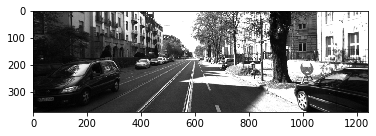

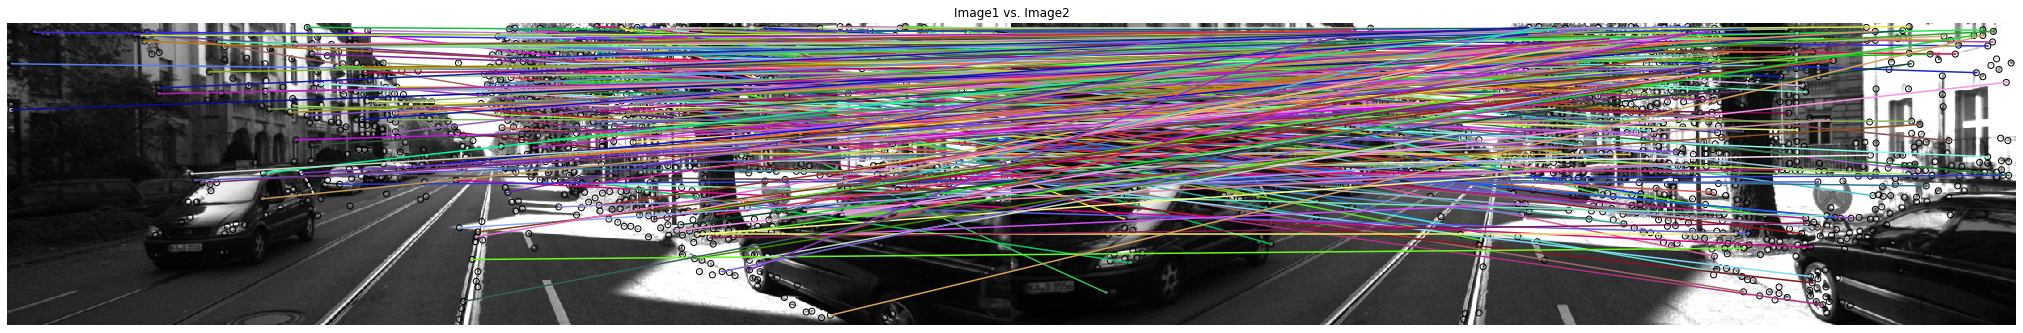

In [30]:
# source: https://github.com/gabilodeau/INF6804/blob/master/Descripteur%20BRIEF.ipynb

img1 = io.imread('KITTI/data_scene_flow/training/image_2/000000_10.png', as_gray= True)
img2 = io.imread('KITTI/data_scene_flow/training/image_2/000000_11.png', as_gray= True)
plt.imshow(img2, cmap='gray')
plt.show()

# extracting key points

kps1 = corner_peaks(corner_fast(img1), min_distance=5)
kps2 = corner_peaks(corner_fast(img2), min_distance=5)

# BRIEF descriptor

extractor = BRIEF(descriptor_size=128, patch_size=5, mode='normal')

extractor.extract(img1, kps1)
descriptor1 = extractor.descriptors
extractor.extract(img2, kps2)
descriptor2 = extractor.descriptors

# matching

matches = match_descriptors(descriptor1, descriptor2, cross_check=True)

# visualization

fig = plt.figure(figsize=(36, 20)) 
ax0 = plt.subplot()
plot_matches(ax0, img1, img2, kps1, kps2, matches)
ax0.axis('off')
ax0.set_title("Image1 vs. Image2")
plt.show()

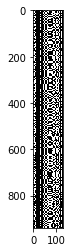

In [27]:
plt.imshow(descriptor1, cmap='gray')
plt.show()

### SGM disparity estimation

In [24]:
# Source: https://github.com/beaupreda/semi-global-matching

def sgm(left_name, right_name, left_gt_name, right_gt_name, output_name='disparity_map.png', disparity=64, save_images=False, evaluation=True):
    """
    main function applying the semi-global matching algorithm.
    :return: recall_left, recall_right
    """
    dawn = t.time()

    parameters = Parameters(max_disparity=disparity, P1=10, P2=120, csize=(7, 7), bsize=(3, 3))
    paths = Paths()

    print('\nLoading images...')
    left, right = load_images(left_name, right_name, parameters)

    print('\nStarting cost computation...')
    left_cost_volume, right_cost_volume = compute_costs(left, right, parameters, save_images)
    if save_images:
        left_disparity_map = np.uint8(normalize(np.argmin(left_cost_volume, axis=2), parameters))
        cv2.imwrite('disp_map_left_cost_volume.png', left_disparity_map)
        right_disparity_map = np.uint8(normalize(np.argmin(right_cost_volume, axis=2), parameters))
        cv2.imwrite('disp_map_right_cost_volume.png', right_disparity_map)

    print('\nStarting left aggregation computation...')
    left_aggregation_volume = aggregate_costs(left_cost_volume, parameters, paths)
    print('\nStarting right aggregation computation...')
    right_aggregation_volume = aggregate_costs(right_cost_volume, parameters, paths)

    print('\nSelecting best disparities...')
    left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), parameters))
    right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), parameters))
    if save_images:
        cv2.imwrite('left_disp_map_no_post_processing.png', left_disparity_map)
        cv2.imwrite('right_disp_map_no_post_processing.png', right_disparity_map)

    print('\nApplying median filter...')
    left_disparity_map = cv2.medianBlur(left_disparity_map, parameters.bsize[0])
    right_disparity_map = cv2.medianBlur(right_disparity_map, parameters.bsize[0])
    cv2.imwrite(f'left_{output_name}', left_disparity_map)
    cv2.imwrite(f'right_{output_name}', right_disparity_map)

    if evaluation:
        print('\nEvaluating left disparity map...')
        recall_left = get_recall(left_disparity_map, left_gt_name, args)
        print('\tRecall = {:.2f}%'.format(recall_left * 100.0))
        print('\nEvaluating right disparity map...')
        recall_right = get_recall(right_disparity_map, right_gt_name, args)
        print('\tRecall = {:.2f}%'.format(recall_right * 100.0))

    dusk = t.time()
    print('\nFin.')
    print('\nTotal execution time = {:.2f}s'.format(dusk - dawn))
    
    return recall_left, recall_right

In [ ]:
rl, rr = sgm('KITTI/data_scene_flow/training/image_2/000000_10.png', 'KITTI/data_scene_flow/training/image_2/000000_11.png', 'KITTI/data_scene_flow/training/disp_noc_0/000000_10.png', 'KITTI/data_scene_flow/training/disp_noc_1/000000_10.png')

In [88]:
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=160,     
    blockSize=1,
    P1=8 * 3 * 3 ** 2,
    P2=32 * 3 * 3 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

for image1, image2, gt1, gt2 in zip(glob.glob('KITTI/data_scene_flow/training/image_2/000000_10.png'), 
                              glob.glob('KITTI/data_scene_flow/training/image_2/000000_11.png'),
                              glob.glob('KITTI/data_scene_flow/training/disp_noc_0/000000_10.png'),
                              glob.glob('KITTI/data_scene_flow/training/disp_noc_1/000000_10.png')):
    
    imgL = io.imread(image1, as_gray= True)
    imgR = io.imread(image2, as_gray= True)
    gtL = io.imread(gt1, as_gray= True)
    gtR = io.imread(gt2, as_gray= True)
    
    # matrix indices to use as "key points"

    indicesL = np.zeros((imgL.shape[0]*imgL.shape[1], 2))
    indicesR = np.zeros((imgR.shape[0]*imgR.shape[1], 2))
    k = 0
    for i in range(imgL.shape[0]):
        for j in range(imgL.shape[1]):
            indicesL[k][0], indicesL[k][1] = i, j
            k += 1
    k = 0
    for i in range(imgR.shape[0]):
        for j in range(imgR.shape[1]):      
            indicesR[k][0], indicesR[k][1] = i, j
            k += 1

    # BRIEF descriptor

    extractor = BRIEF(descriptor_size=128, patch_size=5, mode='normal')

    extractor.extract(imgL, indicesL)
    descriptorL = extractor.descriptors
    extractor.extract(imgR, indicesR)
    descriptorR = extractor.descriptors

    # SGM matching
    
    print('computing disparity...')
    disparity = stereo.compute(descriptorL, descriptorR) #.astype(np.float32)/16
    
    # visualization
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow('left', imgL)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow('right', imgR)
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow('gt', gtL)
    ax4 = fig.add_subplot(2,2,4)
    ax4.imshow('computed disparity', disparity)
    

computing disparity...


TypeError: left data type = 0 is not supported

In [83]:
indicesL.shape

(465750, 2)